# **ECS 7001 - NN & NNLP**

## **Lab 2: Skip-gram Model for Word2Vec**

<br>

**1st February**

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture . In this lab, we will obtain our own word embeddings by training a skip-gram neural network model. Some of the code for this will be supplied here but in some sections, you will be required to implement the code yourself. Hints and
tips will be provided.


The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. There are two ways to train this model: (1) using a hierarchical softmax function and/or (2) by negative sampling. In this lab, we will be training using
negative sampling. To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  

As an example, consider the sentence: “ **The quick brown
fox jumped over the lazy dog** ”. For the target word ' **fox** ' and a window size of 2, all the positive and negative examples drawn from this sentence would be:

Input | label
--| --
(fox, the) | 0
(fox, quick) | 1
(fox, brown) | 1
(fox, jumped) | 1
(fox, over) |1
(fox, lazy) | 0
(fox, dog) | 0

The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


**Sanity check:**

This training corpus contains 16498 sentences. The following print statement should return 16498.

In [ ]:
print(len(austen))

16498


In [ ]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

### **2. Preprocessing the Training Corpus**

In this section, you will write code to remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases. You might also consider removing sentences with fewer than 3 words or at least empty sentences.


**Hints:**
*   The corpus can be accessed as you would a tokenized list, a list of lists, each inner list contains all the tokens in the sentence. Eg:
\>> austen[0] =['[', 'Sense', 'and', 'Sensibility', 'by','Jane', 'Austen', '1811', ']']

*   the python <string> library contains a variable “punctuation”, a string containing all
the special characters.

*   You might want to write a function that takes the corpus as an argument and returns the preprocessed corpus as a list of lists.

 Alternatively, you can use the keras preprocessing library to preprocess the text. More information on the library can be found here:
https://keras.io/preprocessing/text/


**Sanity check:**

After preprocessing the corpus, as a sanity check, print the following line of code. If you chose removed sentences of length with fewer than 3 words, it should be about 13651. 

As a test for your preprocessing function, preprocess the sample below and print the output of your function.

In [ ]:
import string
def preprocess_corpus(corpus):
  
    stop_words = set(stopwords.words('english'))
    #corpus = re.sub(r'[^ A-Za-z0-9]','',corpus)
    normalized_corpus = []
    for i in corpus:
        i = [j for j in i if j.isalpha()]
        i = [c for c in i if c.strip() != 0]
        i = [j.lower() for j in i]
        i = [j for j in i if j not in stop_words]

        #print(i)
        if len(i) > 2:
            #print(len(i))
            normalized_corpus.append(i)
    #normalized_corpus = [x for x in normalized_corpus if x]
    return normalized_corpus


normalized_corpus = preprocess_corpus(austen)
print(normalized_corpus[1])
print('The new length of the preprocessed output', len(normalized_corpus))

['family', 'dashwood', 'long', 'settled', 'sussex']
The new length of the preprocessed output 13923


**<i> <font color ='darkblue'> In this section, we perform basic pre-processing  steps like converting words into lowercase, tokenisation,   removing - punctuations, empty strings, spaces, stopwords. Finally, we checked the number of the remaining tokens and discard the sentences which have less than three tokens. </font></i>**

In [ ]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = preprocess_corpus(sample)


print(len(sample), sample)
print()
print(len(preprocessed_sample), preprocessed_sample)

4 [['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]

2 [['sense', 'sensibility', 'jane', 'austen'], ['mrs', 'dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


### **3. Creating the Corpus Vocabulary and Preparing the Data**


To prepare the data for machine learning, you will write code to prepare 3 variables:

1. \<word2idx>: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. \<idx2word>: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. \<sents_as_ids>: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.


The incomplete code provided below is just a guide. 

In [ ]:
word2idx = {}
idx2word = {}


def prepareData(normalized_corpus):
    i = 0
    for sentence in normalized_corpus:
        for word in sentence:
            if word not in word2idx:
                word2idx[word] = i
                idx2word[i] = word
                i+=1
    return word2idx

#idx2word = {}

def prepareSentsAsId(normalized_corpus):
    i=0
    sents_as_ids = []
    for sentence in normalized_corpus:
        ids= []
        for word in sentence:
            ids.append(word2idx[word])
        sents_as_ids.append(ids)
    return sents_as_ids

word2idx = prepareData(normalized_corpus)
sents_as_ids =prepareSentsAsId(normalized_corpus)
print('Number of unique words:', len(word2idx))
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))

Number of unique words: 10084

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('family', 4), ('dashwood', 5), ('long', 6), ('settled', 7), ('sussex', 8), ('estate', 9)]

Sample idx2word: [(0, 'sense'), (1, 'sensibility'), (2, 'jane'), (3, 'austen'), (4, 'family'), (5, 'dashwood'), (6, 'long'), (7, 'settled'), (8, 'sussex'), (9, 'estate')]

Sample sents_as_id: [[0, 1, 2, 3], [68, 5, 194, 592, 33, 593, 285, 594]]


**<i> <font color ='darkblue'> We create two dictionaries - word2idx which stores the word as the key and the value is a unique integer, and  idx2word which stores the unique integer as the key and the word as the value. We finally make a list which stores sentence as list of integers corresponding to the words in the sentence.</font></i>**

**Sanity Check**

Copy and run the following lines of code:

```
print('Number of unique words:', len(word2idx)**
```
Returns a number between 9800 and 1200, the exact number depends on your preprocessing step. 

```
print('\nSample word2idx: ', list(word2idx.items())[:10])
```

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('the', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]


```
print('\nSample idx2word:', list(idx2word.items())[:10])**
```

Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

```
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))
```

Sample sents_as_id: [[0, 1, 2, 3], [41, 72, 6, 201, 619, 35, 620, 296, 621]]



After you have created the three variables, set the <vocab_size> and <embed_size> variables with the following commands:

In [ ]:
VOCAB_SIZE = len(word2idx) 
EMBED_SIZE = 100 # We are creating 100D embeddings.

In [ ]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10084


### **4. Generating training instances**


In this section we would generate the training examples of the format shown in introduction using the keras skip-gram generator https://keras.io/preprocessing/sequence/ 

In [ ]:
import tensorflow as tf
from keras.preprocessing.sequence import skipgrams
skip_grams = []
for sent in sents_as_ids:
    skip_grams.append(tf.keras.preprocessing.sequence.skipgrams(
        sent, VOCAB_SIZE, window_size=4, negative_samples=1.0, shuffle=True,
        categorical=False, sampling_table=None, seed=None
    ))

**<i> <font color ='darkblue'>  In this section, we create skipgrams using the keras inbuilt function wherein we pass the sentence  in the form of list of integers corresponding to the words in the sentence, vocabulary size and window size of 4 and enabling negative sampling such that it generates one negative sample for each positive sample.</font></i>**

**Sanity Check:**

To view the skip_grams for the first sentence in the training data, run the line of code that follows. The output should look like:

(austen (3), sensibility (1)) -> 1

(austen (3), jane (2)) -> 1

(jane (2), sensibility (1)) -> 1

(jane (2), walked (2639)) -> 0

(jane (2), partridge (7948)) -> 0

(sensibility (1), austen (3)) -> 1

(sensibility (1), beneficial (5587)) -> 0

(sensibility (1), jane (2)) -> 1

(sensibility (1), dreamt (8308)) -> 0

(austen (3), perception (6543)) -> 0

(jane (2), austen (3)) -> 1

(austen (3), imposing (8622)) -> 0


In [ ]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(len(pairs)):
         	print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
        	# the first word and its index
        	idx2word[pairs[i][0]], pairs[i][0],
        	# the second word and its index
        	idx2word[pairs[i][1]], pairs[i][1],
        	# the label
        	labels[i]))


(sensibility (1), jane (2)) -> 1
(jane (2), austen (3)) -> 1
(jane (2), sensibility (1)) -> 1
(sensibility (1), gloominess (2240)) -> 0
(jane (2), several (740)) -> 0
(sensibility (1), changed (2560)) -> 0
(jane (2), afloat (6357)) -> 0
(sensibility (1), austen (3)) -> 1
(austen (3), boys (2374)) -> 0
(austen (3), sensibility (1)) -> 1
(austen (3), jane (2)) -> 1
(austen (3), ended (2969)) -> 0


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model introduced in the previous lab. https://keras.io/getting-started/functional-api-guide/ 

In [ ]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model


The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

####**A. The first step is to initialize and transform the first input using the following lines of code:**

In [ ]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(target_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

####**B. Write similar code for the ‘context_word’ input.**

In [ ]:
# your code for the context_word goes here
context_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(context_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
context_input = Reshape((EMBED_SIZE, ))(context_embedding)

**<i> <font color ='darkblue'>We reuse the code for target embedding to create context embedding but we replace the target embedding input layer by creating an input layer for context and pass that to the context embedding layer. </font></i>**

####**C. Merge the inputs.**

Recall, each training instance is a (target_word, context_word) combination. Since we are trying to learn the degree of closeness between the two words, the model will compute the cosine distance between the two inputs using the <Dot> layer. https://keras.io/layers/merge/, hence fusing the two inputs into one.


In [ ]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

####**D. The Output Layer**

Pass the merged inputs (now a vector with a single number the cosine distance between the two input vectors for each word) into a sigmoid activated neuron. The output of this layer is the output of the model.

**Hint**: Use the <Dense> layer ( https://keras.io/layers/core/ ), with a ‘sigmoid’ activation function.

In [ ]:
# your code for the output layer goes here
import numpy as np
from tensorflow.keras import layers
from keras.layers import Activation

label = Activation('sigmoid')(merged_inputs)

**<i> <font color ='darkblue'>In the output layer, we use sigmoid function as activation function as we are expecting a binary output.</font></i>**

####**E. Initialize the model:**

In [ ]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs=[label])  

####**F. Compile the model using the <model.compile> command.** Use Loss = ‘mean_squared_error’, optimizer = ‘rmsprop’.

In [ ]:
# your code here
model.compile(loss='mse', optimizer = 'rmsprop')


**<i> <font color ='darkblue'>In this code block, we compile the model where mean squared error is used as loss function and the optimizer is rmsprop. </font></i>**

**Sanity check:**

Visualize the model and the model summary by running the following lines of code. 
view the model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1008400     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1008400     input_2[0][0]                    
______________________________________________________________________________________________

####**G. Plot the model using ```vis utils```.**

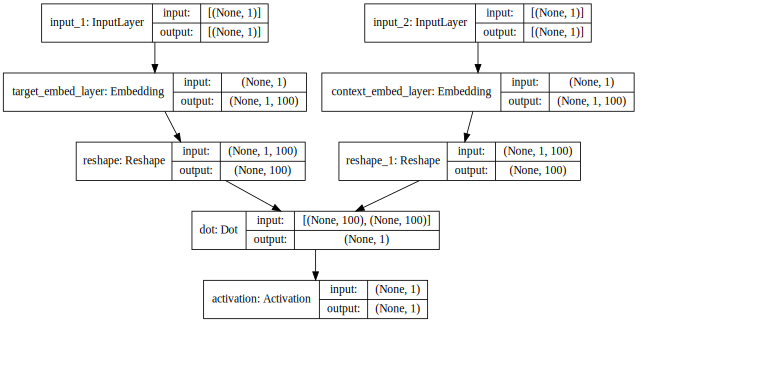

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


###**6.Training the Model**

Run the following block of code to train the model for 5 epochs:

In [ ]:
import numpy as np

NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: 
        	print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')



Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 1 Loss: 2590.3710163030773 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 2 Loss: 2197.0485896533355 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 3 Loss: 2141.438904635608 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 4 Loss: 2095.4548662034795 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 5 Loss: 2033.8358700186945 



The training takes about 10 minutes to run.

<br>

In the introduction, we outlined two approaches to training using the skipgram architecture. In this tutorial, we implemented the negative sampling training approach. While waiting for the training to complete, read this article http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/. It contains the skipgram model with softmax training. 

<br>

After reading the article, answer the following questions:  
●	What would the inputs and outputs to the model be?

●	How would you use the Keras framework to create this architecture?

●	What are the reasons this training approach is 
considered inefficient?


Question 1: What would the inputs and outputs to the model be? <br/>
Answer:
**<i> <font color ='darkblue'> Input to the mentioned model is the one-hot vector representation for target words which are the input words here and the output is in the form of probability distribution which is the output that we get from the softmax function.</font></i>**

Question 2: How would you use the Keras framework to create this architecture? <br/>
Answer: **<i> <font color ='darkblue'>The model architecture will consist of an input layer which takes in input of size equal to the length of one-hot representation of words, a hidden dense layer with 300 units, followed by the output layer with softmax as the activation function as we want the output to be a probability distribution for each word in the vocabulary. The model makes use of gradient descent as an optimizer and has MSE as the loss function. Code for this model is given below:
</font></i>** 

input_layer = Input(shape = (10000,)) <br/>
hidden_dense_layer = Dense(300)(input_layer) <br/>
output_layer = Dense(10000, activation = 'softmax')(hidden_dense_layer) <br/>
model = Model(inputs = input_layer, outputs = output_layer) 

Question 3: What are the reasons this training approach is considered inefficient? <br/>
Answer: **<i> <font color ='darkblue'>The model takes in 10000 words in the vocabulary and has 300 features resulting in 3M weights which needs to be trained and this is computationaly costly and also risks overfitting. Also, probability of choosing common words is higher as compared to the probability of choosing rarer words for which Negative Sampling could be considered.  </font></i>**

###**7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [ ]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10084, 100)


Print out a few words and their embeddings using the next block of code. Your output may not be exactly as above but the command should print 10 words and their respective vectors.

In [ ]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                   0         1         2   ...        97        98        99
sense        0.022132 -0.021818 -0.014919  ... -0.023806  0.006483 -0.005479
sensibility  0.006892  0.013031  0.009114  ... -0.033868 -0.024282 -0.008528
jane        -0.006343 -0.114453 -0.115419  ...  0.026720  0.011113 -0.004903
austen      -0.017108 -0.004009  0.012293  ... -0.038474 -0.023167  0.030859
family      -0.056714 -0.051039 -0.032007  ... -0.036367 -0.015014  0.068005
dashwood    -0.088098  0.094064  0.062374  ... -0.083655  0.032214  0.117312
long         0.002460  0.024011 -0.032046  ...  0.042740 -0.071517  0.116967
settled      0.015020  0.012760 -0.009831  ... -0.013363 -0.016120 -0.001037
sussex      -0.031684  0.029758  0.025280  ...  0.017535 -0.027242  0.019020
estate      -0.007590  0.031553  0.018864  ... -0.004872  0.013545  0.041610

[10 rows x 100 columns]


###**8.  Measuring Similarity Between Word Pairs**



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)   

(10084, 10084)


###**9. Exploring and Visualizing your Word Embeddings using t-SNE**

**A.	Get the most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']


**Sanity check:**
The similar words obtained would depend on your training but the above command should print a dictionary. Each key is a search term and each value is a list of the 5 words the model predicts to be most similar to the key word. 


In [ ]:
import numpy
import operator
import itertools
search_terms = ['think', 'thought', 'mr', 'friend', 'love', 'disdain']

# write code to get the 5 words most similar to the words in search_terms
similar_words = dict()
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

for search_word in search_terms:
    print('Search term: '+search_word)
    index = word2idx[search_word] 
    similar_word_vector = similarity_matrix[index] 
    similar_word_dict = {idx2word[i]:similar_word_vector[i] for i in range(len(similar_word_vector))} 
    sorted_items = dict(sorted(similar_word_dict.items(),key=operator.itemgetter(1), reverse=True)) 
    out = dict(itertools.islice(sorted_items.items(), 5)) 
    print('Similar words: ')
    print(list(out.keys()))

Search term: think
Similar words: 
['think', 'hope', 'never', 'business', 'family']
Search term: thought
Similar words: 
['thought', 'never', 'much', 'father', 'indeed']
Search term: mr
Similar words: 
['mr', 'knightley', 'robert', 'elliot', 'elton']
Search term: friend
Similar words: 
['friend', 'weston', 'way', 'soon', 'first']
Search term: love
Similar words: 
['love', 'rather', 'mother', 'said', 'set']
Search term: disdain
Similar words: 
['disdain', 'gracious', 'precise', 'profits', 'willingness']


 **<i> <font color ='darkblue'>In this task, we fetch the row corresponding to each word we want to find similar words for where the row has values for similarity measure between the word under consideration and the word in each column. We use each index in the extracted list to extract the word using idx2word and create a dictionary similar_word_dict such that key is the extracted similar word and value is the similarity measure. We sort this dictionary items by descending order of similarity measure and display the top 5 dictionary items.  </font></i>**

**B. Plot the words in the dictionary above using t-SN**E https://lvdmaaten.github.io/tsne/ 

Plot 50 of the word embeddings using the code snippets below:














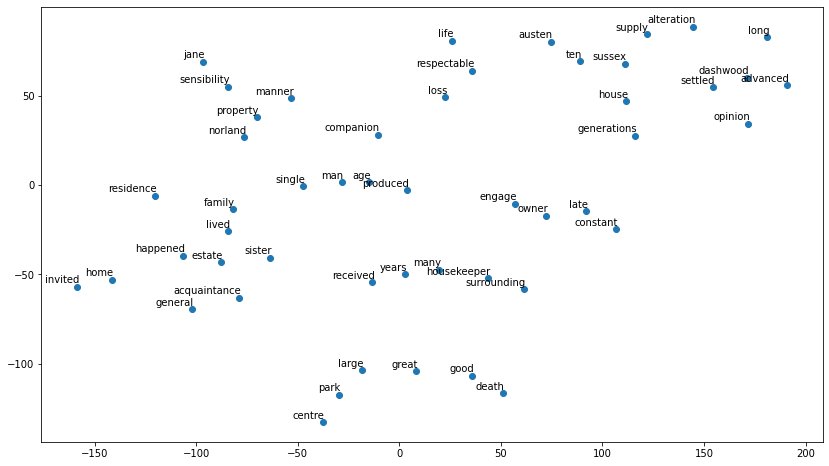

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 

T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        



**10. Resources used**

http://jalammar.github.io/illustrated-word2vec/
https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ 
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/ 
https://www.tensorflow.org/tutorials/representation/word2vec#the_skip-gram_model 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 

